# Framework Mapping with Deep Learning using Bidirectional Encoder Representations from Transformers (BERT)

Previously I designed a number of models using Naive-Bayes & Support Vector Machine algorithms which gave 40-60% accuracy.  The 60% accuracy for the SVM model would be acceptable and cut resource required for FW Mapping in half.  However,  there were a few considerations due to data imbalance so after research I have found a number of methods which should, in theory, significantly out perform SVM and NB.  

The first of these methods is using BERT.
[(Research paper.)](https://)

BERT is a machine learning framework for Natural Language Processing that is open source (NLP). BERT is a programme that uses surrounding text to help computers grasp the meaning of ambiguous words in text. The BERT framework was trained using Wikipedia text and may be fine-tuned using question and answer datasets, or text classification datasets. 

BERT (Bidirectional Encoder Representations from Transformers) is based on Transformers, a deep learning model in which each output element is connected to each input element, and the weightings between them are dynamically calculated based on their connection. (This is referred to as attention in NLP.)

BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1

## Import Dependancies & Load Data

In [1]:
!pip install transformers # install the transformer package

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import dependancies
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification


In [3]:
# load data
df = pd.read_csv("traindata.csv", encoding="Latin 1")
df.head()

,title,fwnum
0,Action Learning Set Courses,RM6145
1,Additions Plant & Machinry,RM6157
2,Additions Software,RM6068
3,Additns-Info Techno,RM6068
4,Adds - Assets Under Construc,RM6088


## Prepare Data

In [4]:
df["fwnum"].value_counts()

RM6068    470
RM3821    272
RM3830    265
RM6088    167
RM3822    151
         ... 
RM3858      1
RM3857      1
RM3856      1
RM3855      1
RM6100      1
Name: fwnum, Length: 156, dtype: int64

As we can see the classes (framework numbers) are imbalanced, this needs to be addressed. 

Encoding the labels helps the model perform more accurately

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df["label"] = le.fit_transform(df["fwnum"])

df


,title,fwnum,label
0,Action Learning Set Courses,RM6145,126
1,Additions Plant & Machinry,RM6157,129
2,Additions Software,RM6068,102
3,Additns-Info Techno,RM6068,102
4,Adds - Assets Under Construc,RM6088,105
...,...,...,...
2373,Security and Information Management,RM1557,4
2374,Cloud Infrastructure Consultancy,RM1557,4
2375,Acorn and Acorn Profiler software with Paychec...,RM1557,4
2376,"Support, Maintenance and upgrade costs for the...",RM1557,4


In [6]:
df["fwnum"].value_counts()

RM6068    470
RM3821    272
RM3830    265
RM6088    167
RM3822    151
         ... 
RM3858      1
RM3857      1
RM3856      1
RM3855      1
RM6100      1
Name: fwnum, Length: 156, dtype: int64

In [7]:
df["freq"] = df.groupby("fwnum")["fwnum"].transform('count')
df.head()

,title,fwnum,label,freq
0,Action Learning Set Courses,RM6145,126,12
1,Additions Plant & Machinry,RM6157,129,11
2,Additions Software,RM6068,102,470
3,Additns-Info Techno,RM6068,102,470
4,Adds - Assets Under Construc,RM6088,105,167


In [8]:
#df.drop(df.index[df["freq"] < 3], inplace=True)

#df

In [9]:
df = df.groupby("fwnum").filter(lambda x: len(x) >= 3)
df

,title,fwnum,label,freq
0,Action Learning Set Courses,RM6145,126,12
1,Additions Plant & Machinry,RM6157,129,11
2,Additions Software,RM6068,102,470
3,Additns-Info Techno,RM6068,102,470
4,Adds - Assets Under Construc,RM6088,105,167
...,...,...,...,...
2373,Security and Information Management,RM1557,4,53
2374,Cloud Infrastructure Consultancy,RM1557,4,53
2375,Acorn and Acorn Profiler software with Paychec...,RM1557,4,53
2376,"Support, Maintenance and upgrade costs for the...",RM1557,4,53


## Split the Data & Stratify the Labels (resampling)

As the dataset is imbalanced it is required to use stratified sampling on the Framework Numbers.  

In [10]:
from sklearn.model_selection import train_test_split

X = df.index.values
y = df.label.values

X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.20, 
                                                  random_state=42, 
                                                  stratify=y)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['title',"fwnum", 'label', 'data_type']).count()

,,,,freq
title,fwnum,label,data_type,
Criminal Justice Inspectorate Website Hosting and Support,RM1557,4,train,1
HMP & YOI Swinfen Hall - Conflict Resolution Training January 2020,RM3822,31,train,1
HMP Bristol Music Workshops,RM3822,31,train,1
HMP Ford Bricklaying,RM3822,31,train,1
HMP Highpoint Warehousing & Distributions 2020 / 2021,RM6074,104,train,1
...,...,...,...,...
new: 3D modelling software @ c. £5k,RM6068,102,val,1
prj_2888 - Provision of Data Links,RM3821,30,train,1
prj_4509 - HMP Whatton-Preperaton for release course- 2020,RM3840,49,train,1


## Tokenization

Tokenization is a process to take raw texts and split into tokens, which are numeric data to represent words.



*   Constructs a [BERT tokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer). Based on WordPiece.
*   Instantiate a pre-trained BERT model configuration to encode our data.
* To convert all the titles from text into encoded form, we use a function called `batch_encode_plus`, and we will proceed train and validation data separately.
* Instantiate a pre-trained BERT model configuration to encode our data.
* To convert all the titles from text into encoded form, we use a function called batch_encode_plus , and we will proceed train and validation data separately.
* The 1st parameter inside the above function is the title text.
* `add_special_tokens=True` means the sequences will be encoded with the special tokens relative to their model.
* When batching sequences together, we set `return_attention_mask=True`, so it will return the attention mask according to the specific tokenizer defined by the `max_length attribute`.
* We also want to pad all the titles to certain maximum length.
* We actually do not need to set `max_length=256`, but just to play it safe. `return_tensors='pt'` to return PyTorch.
* And then we need to split the data into `input_ids`, `attention_masks` and `labels`.
* Finally, after we get encoded data set, we can create training data and validation data.

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].title.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt')

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].title.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt')


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Model Building

We are treating each "title" or "description" as its unique sequence, so one sequence will be classified to one of the FW Number labels.

* `bert-base-uncased` is a smaller pre-trained model.
* Using `num_labels` to indicate the number of output labels.
* We don’t really care about `output_attentions`.
* We also don’t need `output_hidden_states`.

In [12]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(df["label"]),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Dataloading the Model
* `DataLoader` combines a dataset and a sampler, and provides an iterable over the given dataset.
* We use `RandomSampler` for training and `SequentialSampler` for validation.
* Given the limited memory in my environment, I set `batch_size=3`.

In [13]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

### Optimiser & Scheduler
We must supply an optimiser an iterable with the parameters to optimise before we can build it. The learning rate, epsilon, and other optimiser-specific variables can then be specified.

* I found `epochs=30` works well for this data set, with a plateau of around 25-27 epochs.
* Create a schedule with a learning rate that decreases linearly from the initial learning rate set in the optimiser to 0, after a warmup period during which it increases linearly from 0 to the initial learning rate set in the optimizer.

The AdamW is being depreciated in the next version of transformers,  this will be have to be updated in the future if model drift is detected. 

In [14]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 30

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


### Performance Metrics
I will use f1 score and accuracy per class as performance metrics.

The F-measure is the harmonic mean of  precision and recall. In most situations, you have a trade-off between precision and recall. If you optimise your classifier to increase one and disfavor the other, the harmonic mean quickly decreases. It is greatest however, when both precision and recall are equal.

F-measures of 0.4 and 0.8 should be a sweet spot.

For visual reference take a look at this figure:

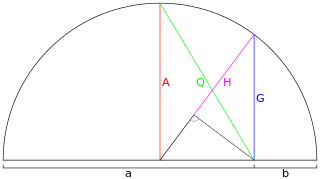

The F-measure is H, A and B are recall and precision. You can increase one, but then the other decreases.

In [15]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in df["label"].items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

## Training the Model



In [16]:
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 1
Training loss: 5.082716138923869
Validation loss: 3.5310120146258983
F1 Score (Weighted): 0.1651978139528466


Epoch 2:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 2
Training loss: 3.139107132756632
Validation loss: 2.850598405584011
F1 Score (Weighted): 0.2589697834259817


Epoch 3:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 3
Training loss: 2.6011124390597438
Validation loss: 2.609005592617334
F1 Score (Weighted): 0.31421283139938333


Epoch 4:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 4
Training loss: 2.2659977048489393
Validation loss: 2.5176680747882214
F1 Score (Weighted): 0.36083496918171276


Epoch 5:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 5
Training loss: 1.9943789893615187
Validation loss: 2.4562801661493343
F1 Score (Weighted): 0.3913571042425963


Epoch 6:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 6
Training loss: 1.762291284226295
Validation loss: 2.55012275587183
F1 Score (Weighted): 0.4201131033321869


Epoch 7:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 7
Training loss: 1.5936418548622016
Validation loss: 2.4714844011598163
F1 Score (Weighted): 0.4720827146452424


Epoch 8:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 8
Training loss: 1.3760439845508123
Validation loss: 2.5214197080296286
F1 Score (Weighted): 0.48752448448701585


Epoch 9:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 9
Training loss: 1.2314841238670722
Validation loss: 2.5048332008064476
F1 Score (Weighted): 0.49617235324475967


Epoch 10:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 10
Training loss: 1.1034269954102247
Validation loss: 2.429327423592993
F1 Score (Weighted): 0.5108839015524612


Epoch 11:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.9820220628030464
Validation loss: 2.541221312798858
F1 Score (Weighted): 0.5212499827468913


Epoch 12:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.8892793082046243
Validation loss: 2.5231629762246146
F1 Score (Weighted): 0.5284205074837449


Epoch 13:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.7936113889087935
Validation loss: 2.544632087116209
F1 Score (Weighted): 0.5385885883228422


Epoch 14:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.726317295368633
Validation loss: 2.493833364208162
F1 Score (Weighted): 0.5589129360040606


Epoch 15:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.6654274229803335
Validation loss: 2.5264638826529513
F1 Score (Weighted): 0.5544697581857267


Epoch 16:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.5997993679835311
Validation loss: 2.5704652085779327
F1 Score (Weighted): 0.5591338419827343


Epoch 17:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.556823326763716
Validation loss: 2.6135004210054533
F1 Score (Weighted): 0.5557062401977572


Epoch 18:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.5167243675143516
Validation loss: 2.623754068963333
F1 Score (Weighted): 0.5636919610846428


Epoch 19:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.47722808880563306
Validation loss: 2.6950856683613336
F1 Score (Weighted): 0.5680954523059786


Epoch 20:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.4542164551241596
Validation loss: 2.6264575540024966
F1 Score (Weighted): 0.5800413771916102


Epoch 21:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 21
Training loss: 0.42112063135906297
Validation loss: 2.706347768615552
F1 Score (Weighted): 0.5720730065806326


Epoch 22:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 22
Training loss: 0.3961515431086441
Validation loss: 2.718034337399325
F1 Score (Weighted): 0.5767851447662629


Epoch 23:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 23
Training loss: 0.3727561322484927
Validation loss: 2.731911398713504
F1 Score (Weighted): 0.5761617525493506


Epoch 24:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 24
Training loss: 0.36015499519861227
Validation loss: 2.7269413108252456
F1 Score (Weighted): 0.5785360249416898


Epoch 25:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 25
Training loss: 0.34389326268071085
Validation loss: 2.72890671370726
F1 Score (Weighted): 0.5755043849918859


Epoch 26:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 26
Training loss: 0.3246518745144344
Validation loss: 2.7257330921381366
F1 Score (Weighted): 0.5860074971062799


Epoch 27:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 27
Training loss: 0.3266895292749574
Validation loss: 2.7593049309003392
F1 Score (Weighted): 0.5841281866117443


Epoch 28:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 28
Training loss: 0.3142589909321567
Validation loss: 2.7427941769755444
F1 Score (Weighted): 0.5879395715474504


Epoch 29:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 29
Training loss: 0.30763943547522193
Validation loss: 2.749712875709044
F1 Score (Weighted): 0.5825532870201847


Epoch 30:   0%|          | 0/612 [00:00<?, ?it/s]


Epoch 30
Training loss: 0.30107065317473697
Validation loss: 2.7507954663301253
F1 Score (Weighted): 0.5783904382187138


## Loading and Evaluating the Model

In [18]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(df["label"]),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load("finetuned_BERT_epoch_28.model", map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: 2078
Accuracy: 0/2

Class: 2013
Accuracy: 3/3

Class: 2377
Accuracy: 4/11

Class: 1752
Accuracy: 0/1

Class: 2106
Accuracy: 1/4

Class: 1922
Accuracy: 0/4

Class: 2084
Accuracy: 0/3

Class: 2021
Accuracy: 1/2

Class: 2007
Accuracy: 0/1

Class: 1707
Accuracy: 0/1

Class: 2016
Accuracy: 2/2

Class: 1884
Accuracy: 1/2

Class: 330
Accuracy: 0/1

Class: 2082
Accuracy: 0/1

Class: 2109
Accuracy: 0/3

Class: 2372
Accuracy: 11/14

Class: 2371
Accuracy: 0/1

Class: 2302
Accuracy: 0/1

Class: 2046
Accuracy: 0/1

Class: 2369
Accuracy: 29/54

Class: 1726
Accuracy: 28/30

Class: 1995
Accuracy: 0/2

Class: 2294
Accuracy: 1/3

Class: 1358
Accuracy: 0/1

Class: 1364
Accuracy: 0/1

Class: 1370
Accuracy: 0/1

Class: 2027
Accuracy: 0/2

Class: 1380
Accuracy: 0/1

Class: 2365
Accuracy: 39/53

Class: 1404
Accuracy: 0/1

Class: 1409
Accuracy: 0/1

Class: 1413
Accuracy: 0/1

Class: 1416
Accuracy: 0/1

Class: 1419
Accuracy: 0/1

Class: 2123
Accuracy: 5/5

Class: 1451
Accuracy: 0/1

Class: 1895
Accuracy